# Togo EDA

This notebook contains an end-to-end scaffold for profiling, cleaning, and exploratory analysis of the Togo solar dataset.

Notes:
- Place your raw CSV at `data/togo.csv`. Do NOT commit CSV files (data/ is in `.gitignore`).
- The cleaned DataFrame is exported to `data/togo_clean.csv`.

In [1]:
# Imports and setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# plotting defaults
%matplotlib inline
sns.set(style='whitegrid')

pd.options.display.max_columns = 200
pd.options.display.float_format = '{:.3f}'.format

In [2]:
# Load data (adjust Timestamp column name if different)
candidate_paths = ['data/togo.csv', '../data/togo.csv', './data/togo.csv']
data_path = None
for p in candidate_paths:
    if os.path.exists(p):
        data_path = p
        break
if data_path is None:
    print(f'WARNING: none of the candidate data paths found: {candidate_paths}')
    raise FileNotFoundError('togo CSV not found in expected locations')

# Read CSV, try parsing Timestamp if present
try:
    df = pd.read_csv(data_path, parse_dates=['Timestamp'])
except Exception:
    df = pd.read_csv(data_path)
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

print('Using data file:', data_path)
print('Rows, Columns:', df.shape)
df.head()

Using data file: ../data/togo.csv
Rows, Columns: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.300,0.000,0.000,0.000,0.000,24.800,94.500,0.900,1.100,0.400,227.600,1.100,977,0,0.000,24.700,24.400,NaN
1,2021-10-25 00:02:00,-1.300,0.000,0.000,0.000,0.000,24.800,94.400,1.100,1.600,0.400,229.300,0.700,977,0,0.000,24.700,24.400,NaN
2,2021-10-25 00:03:00,-1.300,0.000,0.000,0.000,0.000,24.800,94.400,1.200,1.400,0.300,228.500,2.900,977,0,0.000,24.700,24.400,NaN
3,2021-10-25 00:04:00,-1.200,0.000,0.000,0.000,0.000,24.800,94.300,1.200,1.600,0.300,229.100,4.600,977,0,0.000,24.700,24.400,NaN
4,2021-10-25 00:05:00,-1.200,0.000,0.000,0.000,0.000,24.800,94.000,1.300,1.600,0.400,227.500,1.600,977,0,0.000,24.700,24.400,NaN


## Summary statistics & missing-value report
Run descriptive stats on numeric columns and find columns with >5% nulls.

In [3]:
# Summary statistics
num_desc = df.describe(include=[np.number]).T
num_desc

,count,mean,std,min,25%,50%,75%,max
GHI,525600.000,230.555,322.532,-12.700,-2.200,2.100,442.400,1424.000
DNI,525600.000,151.258,250.957,0.000,0.000,0.000,246.400,1004.500
DHI,525600.000,116.444,156.521,0.000,0.000,2.500,215.700,805.700
ModA,525600.000,226.144,317.347,0.000,0.000,4.400,422.525,1380.000
ModB,525600.000,219.569,307.933,0.000,0.000,4.300,411.000,1367.000
Tamb,525600.000,27.752,4.758,14.900,24.200,27.200,31.100,41.400
RH,525600.000,55.013,28.779,3.300,26.500,59.300,80.800,99.800
WS,525600.000,2.368,1.463,0.000,1.400,2.200,3.200,16.100
WSgust,525600.000,3.229,1.883,0.000,1.900,2.900,4.400,23.100
WSstdev,525600.000,0.558,0.269,0.000,0.400,0.500,0.700,4.700


In [4]:
# Missing values summary
na_counts = df.isna().sum()
na_pct = (na_counts / len(df)) * 100
missing_report = pd.DataFrame({'n_missing': na_counts, 'pct_missing': na_pct})
missing_report.sort_values('pct_missing', ascending=False).head(40)
cols_gt5pct = missing_report[missing_report['pct_missing'] > 5].index.tolist()
print('Columns with >5% nulls:', cols_gt5pct)

Columns with >5% nulls: ['Comments']


## Outlier detection & basic cleaning
Compute Z-scores for core numeric sensors and flag extreme rows (|Z| > 3). Then impute medians for key columns.

In [5]:
# Key measurement columns to check - adjust names if your CSV uses different headers
key_cols = [c for c in ['GHI','DNI','DHI','ModA','ModB','WS','WSgust'] if c in df.columns]
key_cols

['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

In [6]:
# compute z-scores (omit NaNs) and flag outliers
z_df = pd.DataFrame(index=df.index)
for c in key_cols:
    try:
        z_df[c] = stats.zscore(df[c].astype(float), nan_policy='omit')
    except Exception:
        z_df[c] = np.nan
outlier_mask = (z_df.abs() > 3).any(axis=1)
df['outlier_flag'] = outlier_mask
print('Outliers flagged:', df['outlier_flag'].sum())

Outliers flagged: 9251


In [7]:
# Impute median for key columns (safe, robust)
for c in key_cols:
    if df[c].isna().any():
        med = df[c].median()
        df[c] = df[c].fillna(med)
        print(f'Imputed median for {c}: {med}')

In [8]:
# Export cleaned dataframe
out_path = '../data/togo_clean.csv'
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df.to_csv(out_path, index=False)
print('Wrote cleaned CSV to', out_path)

Wrote cleaned CSV to ../data/togo_clean.csv


## Time series analysis
Plot GHI, DNI, DHI, Tamb vs Timestamp and inspect daily/monthly patterns.

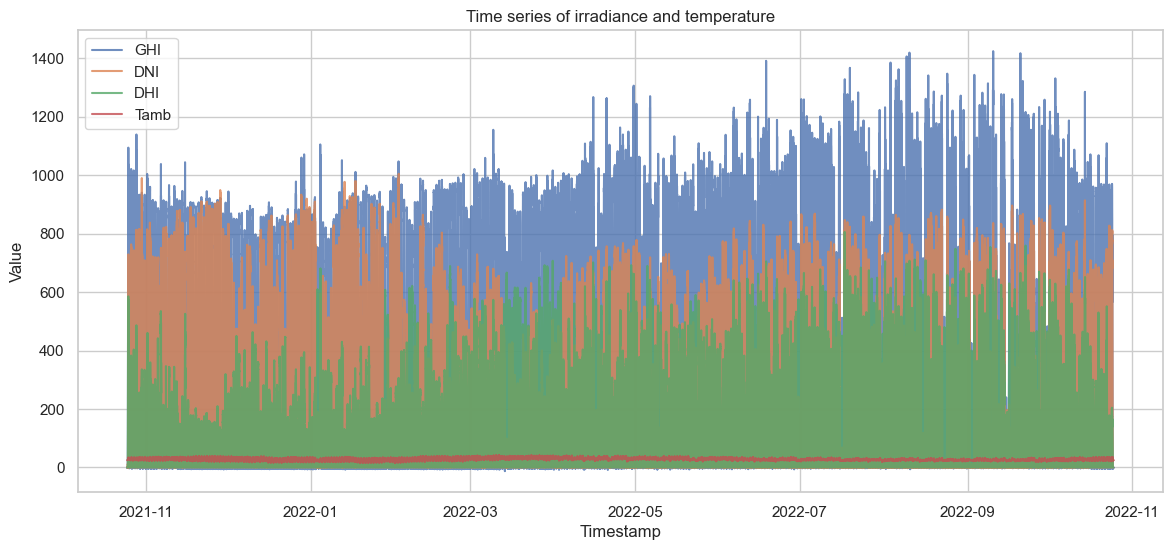

In [9]:
ts_cols = [c for c in ['GHI','DNI','DHI','Tamb'] if c in df.columns]
if 'Timestamp' in df.columns:
    df = df.sort_values('Timestamp')
    plt.figure(figsize=(14,6))
    for c in ts_cols:
        plt.plot(df['Timestamp'], df[c], label=c, alpha=0.8)
    plt.legend()
    plt.title('Time series of irradiance and temperature')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.show()
else:
    print('No Timestamp column found; cannot plot time series')

## Correlations & relationships
Heatmap for correlations and scatter plots to investigate relationships.

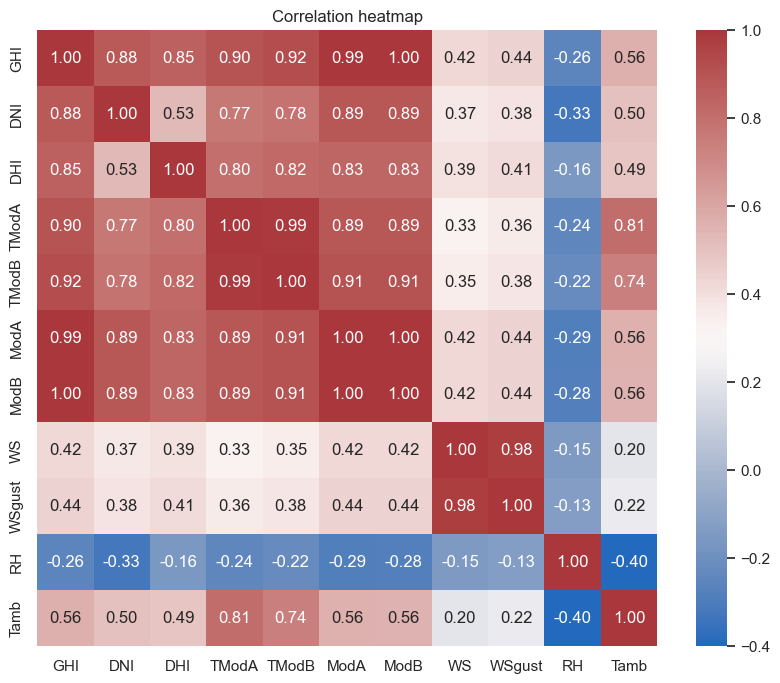

In [10]:
corr_cols = [c for c in ['GHI','DNI','DHI','TModA','TModB','ModA','ModB','WS','WSgust','RH','Tamb'] if c in df.columns]
if corr_cols:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[corr_cols].corr(), annot=True, fmt='.2f', cmap='vlag')
    plt.title('Correlation heatmap')
    plt.show()
else:
    print('No correlation columns found from the expected list')

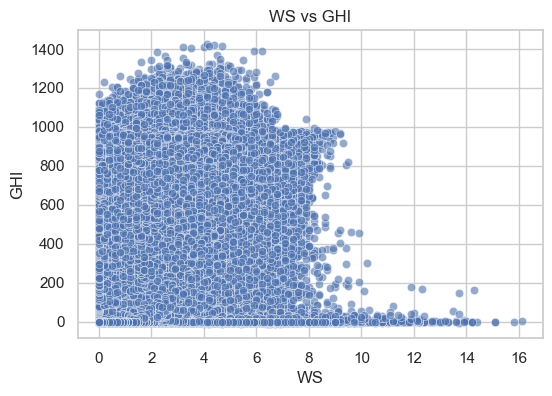

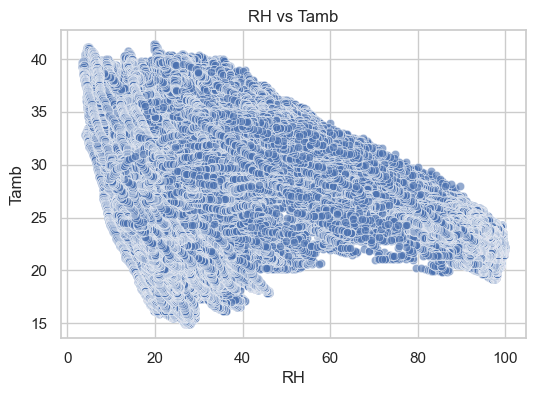

In [11]:
# scatter examples
if 'WS' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='WS', y='GHI', data=df, alpha=0.6)
    plt.title('WS vs GHI')
    plt.show()

if 'RH' in df.columns and 'Tamb' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.6)
    plt.title('RH vs Tamb')
    plt.show()

## Wind & distribution analysis
If you have wind direction (`WD`) and speed (`WS`) the section below attempts a simple radial histogram (wind rose approximation).

/var/folders/vm/q7zjyvps4y32qm7ww0kqs9400000gn/T/ipykernel_70968/468452098.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rose = df.groupby('wd_bin')['WS'].mean().reset_index()


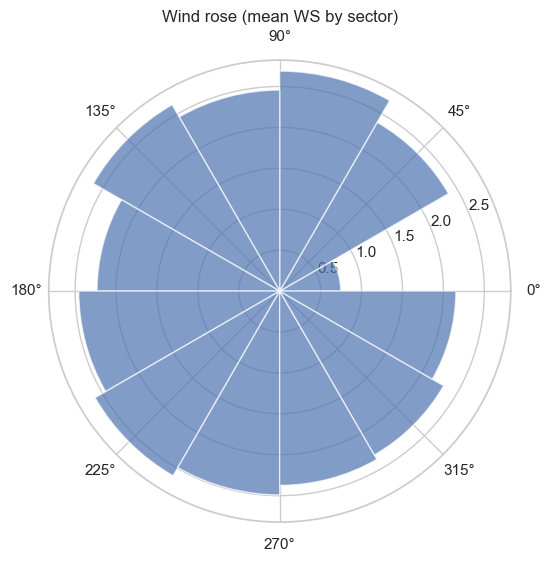

In [12]:
if set(['WD','WS']).issubset(df.columns):
    bins = np.arange(0, 361, 30)
    df['wd_bin'] = pd.cut(df['WD'] % 360, bins=bins, include_lowest=True)
    rose = df.groupby('wd_bin')['WS'].mean().reset_index()
    angles = np.deg2rad((bins[:-1] + bins[1:]) / 2)
    values = rose['WS'].values
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    ax.bar(angles, values, width=np.deg2rad(30), bottom=0.0, alpha=0.7)
    ax.set_title('Wind rose (mean WS by sector)')
    plt.show()
else:
    print('WD or WS columns missing; skipping wind rose')

## Temperature & humidity interactions
Look at RH influence on temperature and solar radiation.

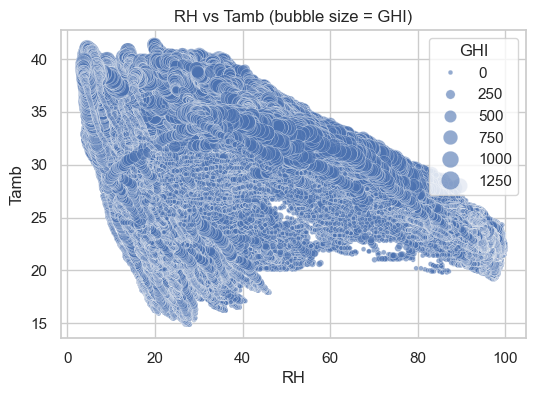

In [13]:
if 'RH' in df.columns and 'Tamb' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='RH', y='Tamb', size='GHI', data=df, alpha=0.6, sizes=(10,200))
    plt.title('RH vs Tamb (bubble size = GHI)')
    plt.show()
else:
    print('One of RH, Tamb, or GHI is missing; skipping bubble chart')

## Notes & next steps
- Consider adding `pytest` and a small test that validates the cleaned CSV schema.
- If you want automated profiling, consider `pandas-profiling` or `ydata-profiling` (add to `requirements-dev.txt`).
- For heavy datasets, work with chunked reads or Dask.